# 튜토리얼

https://www.tensorflow.org/tutorials/quickstart/advanced

이것부터 시작한다.

### 1. 전문가를 위한 빠른 시작

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32") # ...은 reshape -1처럼 알아서 채우라는 소리래
x_test = x_test[..., tf.newaxis].astype("float32")

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# 데이터 셋 객체로 만드려면 nd 어레이기만 하면 된다.
type(x_train)

numpy.ndarray

In [ ]:
# 데이터와 라벨을 합치고 섞고 배치를 만든다. -> train만 섞음
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [ ]:
# from tensorflow.keras import Model 이것을 상속받고
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__() # 이게 국룰
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x): # 순전파
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

In [ ]:
# 이수안님이 말씀하신 일반적인 손실, 최적화 함수 선언법 -> 내가 튜닝할 수 있도록
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [ ]:
# 평가 지표 역시 객체로 생성
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

무조건 이렇게 할 필요는 없고 공부하다가 이러한 방식이 필요하다는 생각이 들면 깊게 공부하자

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [ ]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 0.13314154744148254, Accuracy: 96.05166625976562, Test Loss: 0.06569099426269531, Test Accuracy: 97.79999542236328
Epoch 2, Loss: 0.041330330073833466, Accuracy: 98.7249984741211, Test Loss: 0.05409188196063042, Test Accuracy: 98.22999572753906
Epoch 3, Loss: 0.020107703283429146, Accuracy: 99.37000274658203, Test Loss: 0.061686042696237564, Test Accuracy: 98.25
Epoch 4, Loss: 0.013890020549297333, Accuracy: 99.51499938964844, Test Loss: 0.059307560324668884, Test Accuracy: 98.3499984741211
Epoch 5, Loss: 0.007722945883870125, Accuracy: 99.76499938964844, Test Loss: 0.0570971816778183, Test Accuracy: 98.48999786376953


### TF Hub를 사용한 텍스트 분류

#### 영화 리뷰 텍스트 분류하기 

In [ ]:
!pip install tensorflow-hub
!pip install tensorflow-datasets

import os
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)

# gpu 리스트가 비어있지 않으면 avail
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Version:  2.9.2
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [ ]:
# imdb 리뷰 데이터
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete6LV7TY/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete6LV7TY/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete6LV7TY/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# 데이터 셋 객체를 iter로 만들고 next로 다음 배치 다음 배치 보기
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

tf 데이터셋 객체로 만들면 이런 규격화가 잘 되어서 공식 사이트를 참고하기 좋겠어

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[],  # tf2 방식이 kerasLayer
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])  # 3개의 문장 임베딩 결과

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423195 , -0.0119017 ,  0.06337538,  0.06862972, -0.16776837,
        -0.10581174,  0.16865303, -0.04998824, -0.31148055,  0.07910346,
         0.15442263,  0.01488662,  0.03930153,  0.19772711, -0.12215476,
        -0.04120981, -0.2704109 , -0.21922152,  0.26517662, -0.80739075,
         0.25833532, -0.3100421 ,  0.28683215,  0.1943387 , -0.29036492,
         0.03862849, -0.7844411 , -0.0479324 ,  0.4110299 , -0.36388892,
        -0.58034706,  0.30269456,  0.3630897 , -0.15227164, -0.44391504,
         0.19462997,  0.19528408,  0.05666234,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201318 , -0.04418665, -0.08550783,
        -0.55847436, -0.23336391, -0.20782952, -0.03543064, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862679,  0.7753425 , -0.07667089,
        -0.15752277,  0.01872335, -0.08169781, -0.3521876 ,  0.4637341 ,
        -0.08492756,  0.07166859, -0.00670817,  0.12686075, -0.19326553,
 

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense_2 (Dense)             (None, 16)                816       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


## Keras Tuner 소개

1.개요
최적의 하이퍼 파라미터 세트를 선택하는데 도움을 주는 라이브러리이다.하이퍼 파라미터 튜닝을 해준다. 

-> 이 튜토리얼에서 Tuner를 사용하여 이미지 분류에 하이퍼 튜닝을 수행한다.

-> 하퍼는 두가지가 있다.

1) 레이어, 깊이,너비, 뉴런 등 모델을 구축할 때 영향을 미치는 모델 하퍼

2) SGD의 학습률 및 KNN의 이웃 수 등 하퍼

In [ ]:
import tensorflow as tf
from tensorflow import keras

import IPython

In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt

     |████████████████████████████████| 135 kB 5.0 MB/s 
     |████████████████████████████████| 1.6 MB 46.7 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

2.모델 정의하기

-> 2가지가 있다.
1) 모델 빌더 함수 사용
2) keras tuner api의 HyperModel 클래스를 하위 클래스화


이 튜토리얼에서는 모델 빌더 함수를 사용하여 이미지 분류 모델 정의하고 모델 빌더 함수는 컴파일된 모델을 반환하고 인라인으로 정의한 하퍼를 사용하며 모델을 하이퍼 튜닝힌다. = 이건 1) 모델 하퍼 튜닝이다.

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer(뉴런 수)
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32) # 최소 32, 최대 512로 튜닝
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
  model.add(keras.layers.Dense(10))

  # Tune 러닝레이트
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                metrics = ['accuracy'])

  return model

3.튜너를 인스턴스화하고 하퍼튜닝 수행하기

위에서는 모델을 했으니 이제는 에폭같은 하퍼 튜닝을 보자

-> Keras Tuner에는 RandomSearch, Hyperband, BayesianOptimization 및 Sklearn의 네 가지 튜너가 있다. 이 튜토리얼에서는 Hyperband 튜너를 사용한다.

Hyperband 튜너를 인스턴스화하려면 최적화할 하이퍼모델와 및 훈련할 최대 epoch 수 등을 지정해야 한다.

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

In [ ]:
# 하이퍼 파라미터 검색을 실행하기 전에 훈련 단계가 끝날 때마다 훈련 결과를 지우도록 콜백
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
# 하퍼 검색
tuner.search(img_train, label_train, epochs = 1, validation_data = (img_test, label_test), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 17 Complete [00h 01m 09s]
val_accuracy: 0.8795999884605408

Best val_accuracy So Far: 0.8795999884605408
Total elapsed time: 00h 07m 25s

Search: Running Trial #18

Value             |Best Value So Far |Hyperparameter
448               |480               |units
0.001             |0.001             |learning_rate
10                |10                |tuner/epochs
4                 |4                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
2                 |2                 |tuner/round
0013              |0015              |tuner/trial_id

Epoch 5/10
1458/1875 [======================>.......] - ETA: 2s - loss: 0.4975 - accuracy: 0.8244

KeyboardInterrupt: ignored

In [ ]:
# 검색을 마치고 최적의 하퍼로 모델 재훈련
model = tuner.hypermodel.build(best_hps)
model.fit(img_train, label_train, epochs = 10, validation_data = (img_test, label_test))

NameError: ignored

# 데이터 로드 및 전처리하기

### 이미지

고급 Keras 전처리 유틸리티 및 레이어를 사용하고. 다음으로 tf.data를 사용하여 처음부터 자체 입력 파이프라인을 작성까지 해보자

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 5s 0us/step


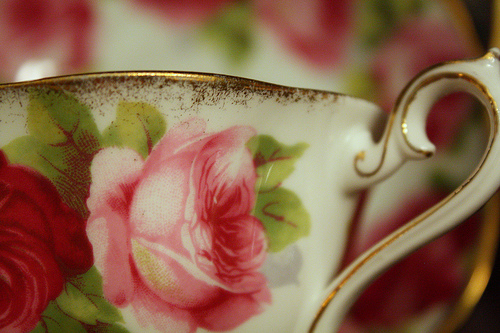

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


### tf.keras.preprocessing.image_dataset_from_directory를 사용하여 이미지를 디스크에서 로드

In [6]:
batch_size = 32
img_height = 180
img_width = 180

```
dir 경로만 있으면 데이터를 가져올 수 있나봐

+ 이렇게 가져오면 바로 tf 데이터셋 객체이다.
```

In [4]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


### 데이터 normalize

255로 나누는게 더 나을 듯 하다.

In [9]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

```
이 노말라이즈 레이어를 사용하는 방법에는 map으로 하는 것이 있다.
```

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [13]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [14]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 139s 1s/step - loss: 1.2682 - accuracy: 0.4625 - val_loss: 1.1085 - val_accuracy: 0.5545
Epoch 2/3
92/92 [==============================] - 134s 1s/step - loss: 0.9941 - accuracy: 0.6114 - val_loss: 1.0358 - val_accuracy: 0.5872
Epoch 3/3
92/92 [==============================] - 133s 1s/step - loss: 0.8174 - accuracy: 0.6904 - val_loss: 1.0537 - val_accuracy: 0.6158


### 텍스트

텍스트를 로드하고 사전 처리하는 두가지 방법을 보여준다.


1. 케라스의 유틸리티와 전처리 계층을 사용한다. 여기에는 데이터를 tf.keras.utils.text_dataset_from_directory 으로 변환하는 tf.data.Dataset 와 데이터 표준화, 토큰화 및 벡터화를 위한 tf.keras.layers.TextVectorization 이 있다.



2. tf.data.TextLineDataset 과 같은 하위 수준 유틸리티를 사용하여 텍스트 파일을 로드하고 TensorFlow Text API(예: text.UnicodeScriptTokenizer 및 text.case_fold_utf8 )를 사용하여 더 세밀한 제어를 위해 데이터를 사전 처리한다.

In [ ]:
# tensorflow_text를 설치하는 과정에서 이슈가 있다.
!pip uninstall -y tensorflow
!pip uninstall -y tensorflow_text

!pip install -U "tensorflow==2.8.*"
!pip install -U "tensorflow-text==2.8.*"